# How to simplify spatio-temporal data analysis

##  Data loading

In [1]:
import datetime as dt
from sttn.data.nyc import NycTaxiDataProvider

provider = NycTaxiDataProvider()
network = provider.get_data('yellow', dt.datetime(2020, 6, 1), dt.datetime(2020, 6, 30))

Network object is represented by directed multigraph with labels:

***V*** - set of nodes (taxi zones)

***E*** - set of edges (taxi trips)

![title](img/manhattan_taxi_zones.png)

In this case nodes are static. Edges represent events that happen in time.

In [3]:
# number of nodes, number of edges
network.shape()

(258, 469083)

## Easy integration with Pandas, networkx and geopandas

<AxesSubplot:xlabel='time'>

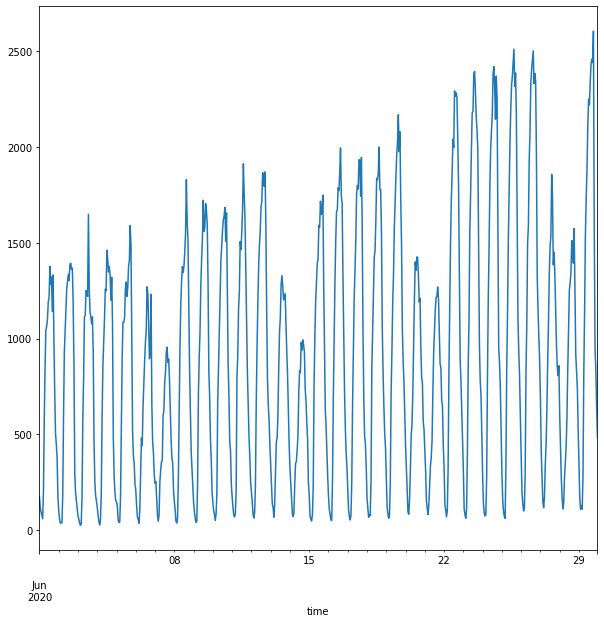

In [3]:
# time projection of ridership
network.edges.resample('1h', on='time').passenger_count.sum().plot(figsize=(10,10))

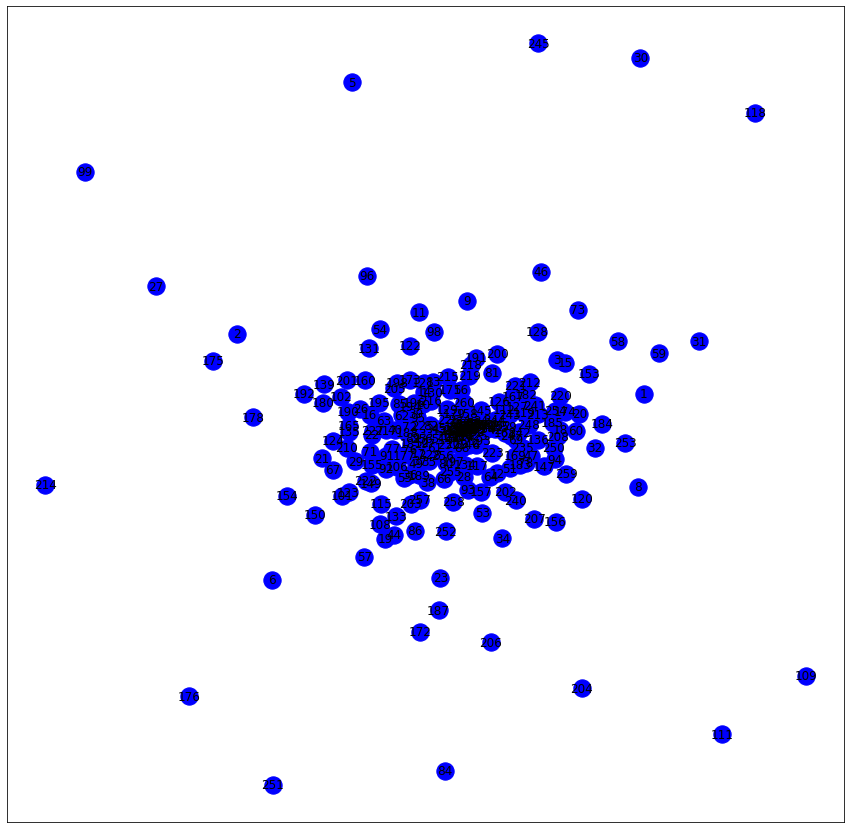

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
pos = nx.fruchterman_reingold_layout(network.to_multigraph(), k=0.3)
nodes = nx.draw_networkx_nodes(network.to_multigraph(), pos, node_color="blue")
labels = nx.draw_networkx_labels(network.to_multigraph(), pos)
# Network "anomalies"
# 111 - Green-Wood Cemetery
# 5, 84, 99, 214, 245 - Staten Island

## Network aggregation API

![title](img/agg_parallel_edges.png)

In [6]:
aggregated = network.agg_parallel_edges({'passenger_count': 'sum'})
aggregated.shape()

(263, 16124)

![title](img/agg_adjacent_edges.png)

<AxesSubplot:>

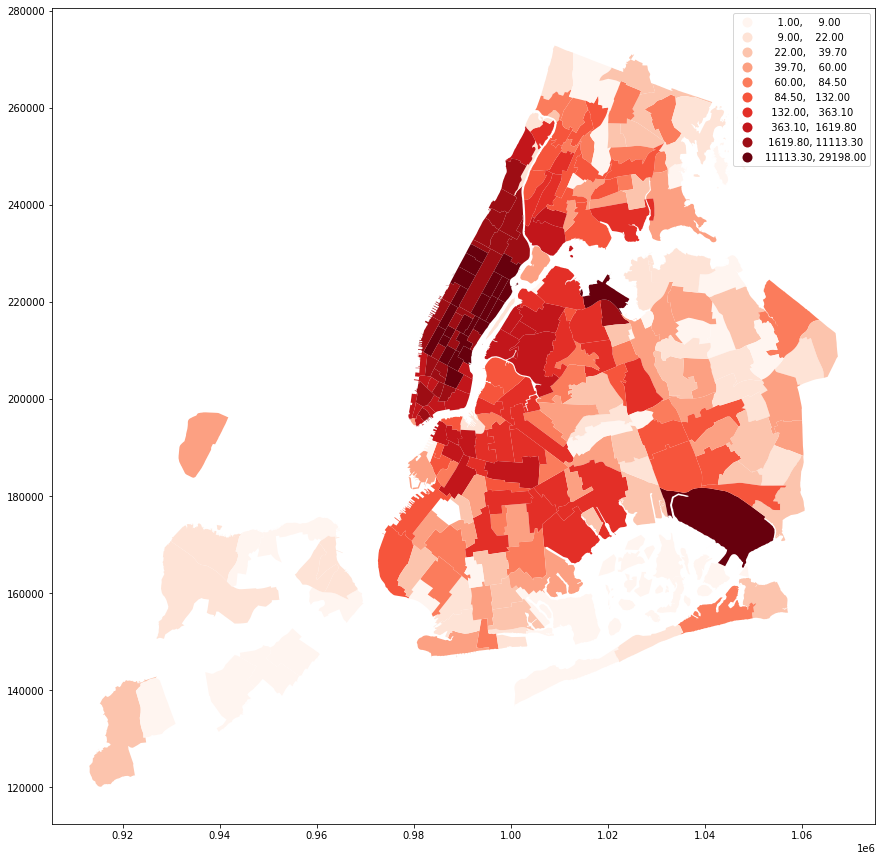

In [8]:
outgoing_trips = network.agg_adjacent_edges(aggs = {'passenger_count': 'sum'}, outgoing = True)\
.rename(columns={'passenger_count': 'outgoing_passenger_count'})

outgoing_agg_network = network.join_node_labels(outgoing_trips)
outgoing_agg_network.nodes.plot(figsize=(15,15), column='outgoing_passenger_count', cmap="Reds", scheme='quantiles', k=10, legend=True)

![title](img/group_nodes.png)

<AxesSubplot:>

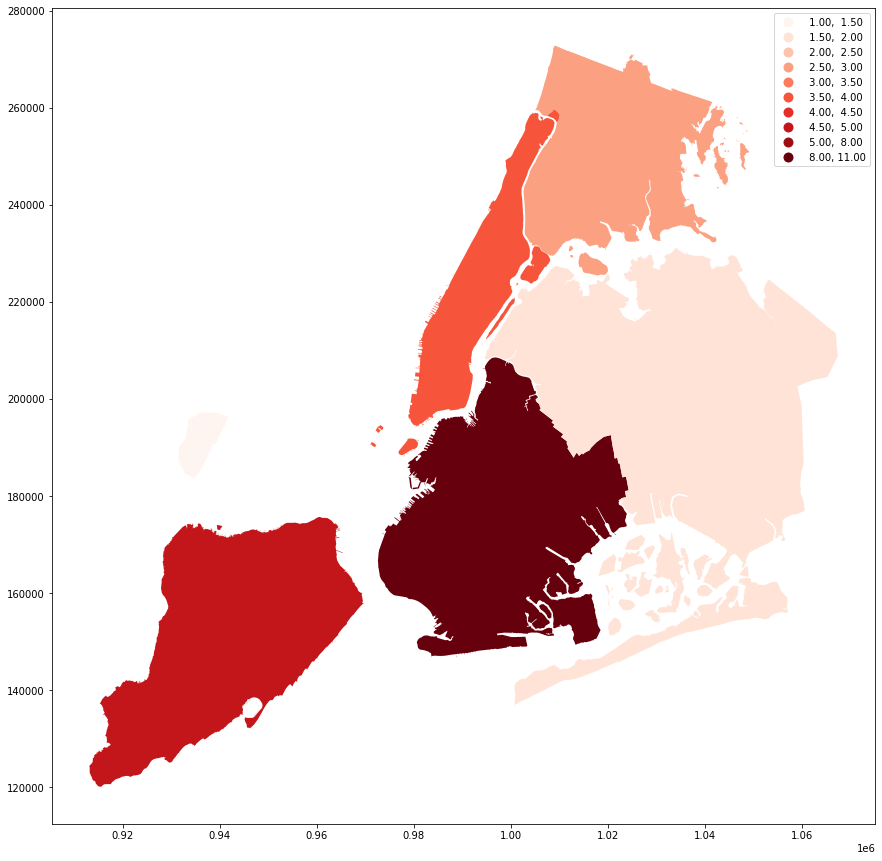

In [17]:
grouped = network.group_nodes('borough')
#grouped.plot(figsize=(15,15), cmap='tab10')
grouped.nodes.plot(figsize=(15,15), column='LocationID', cmap="Reds", scheme='quantiles', k=10, legend=True)

<AxesSubplot:>

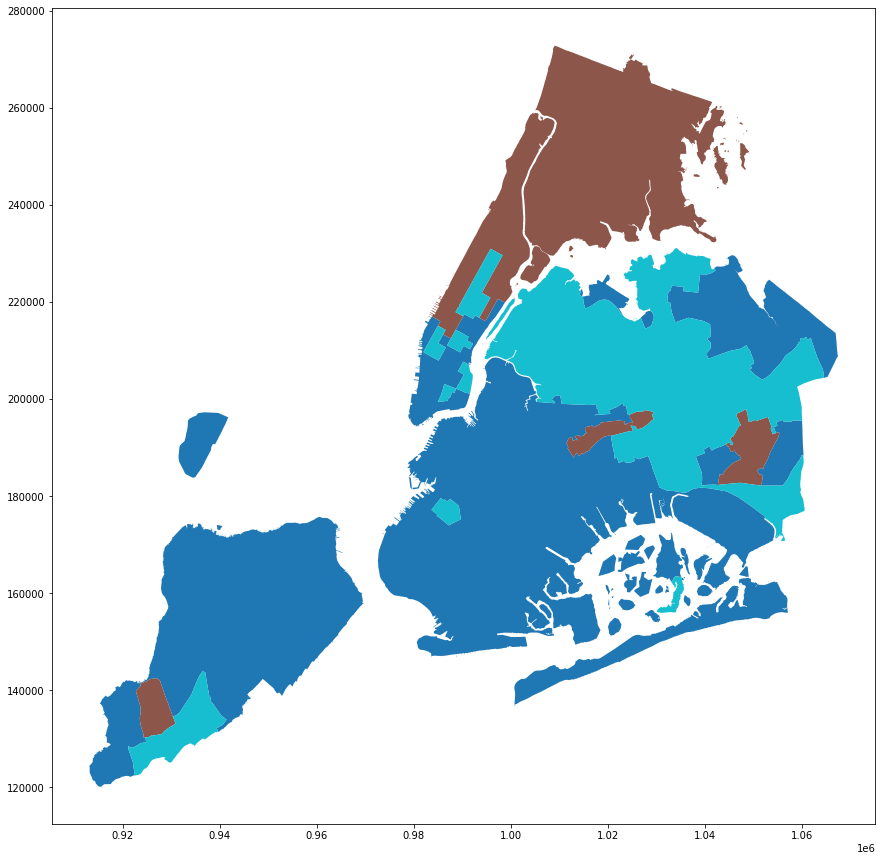

In [37]:
# fluid - Fluid Communities algorithm
# clm - Clauset-Newman-Moore greedy modularity maximization algorithm
communities = aggregated.detect_communities('clm')
communities_network = aggregated.group_nodes(communities)
communities_network.plot(figsize=(15,15), cmap='tab10')